# Cleaning anomalies in time series per region slug



## Load  libraries

In [90]:
# %load first_cell.py
%reload_ext autoreload
%autoreload 2
from pathlib import Path
home = str(Path.home())

import sys
sys.path = sys.path + [f'{home}/.conda/envs/norm_env/lib/python37.zip', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/lib-dynload', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/site-packages']
sys.prefix = '/home/soniame/.conda/envs/norm_env'

from paths import RAW_PATH, TREAT_PATH, OUTPUT_PATH, FIGURES_PATH

In [25]:
#import pandas as pd  
#import datetime 
#dates = pd.Series(['2010-11-01','2010-11-02','2010-11-03',
#               '2010-12-24', '2010-12-25', '2010-12-26', 
#               '2010-12-27', '2010-12-28', '2010-12-29', 
#               '2010-12-30', '2011-01-01', '2011-01-02'])

#### Run single

In [104]:
from src.runners.clean import _run_single 

../src/utils.py:158: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


2021-04-28 21:10:26.028 | INFO     | src.runners.clean:_run_single:814 - ... here we go mexicocity...

2021-04-28 21:10:26.029 | DEBUG    | src.runners.clean:_reading_data:678 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('mexicocity')
        
2021-04-28 21:10:29.461 | DEBUG    | src.runners.clean:_c_param:353 - C max: 1.2739730879698026
2021-04-28 21:10:29.464 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 21:10:29.465 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 21:10:29.465 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-04-28 21:10:29.467 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 21:10:29.473 | DEBUG    | src.runners.clean:_c_tru

         last_updated_utc region_slug       region_name country_name  \
0 2021-04-28 10:40:26.419  mexicocity  Ciudad de México       Mexico   
1 2021-04-28 10:40:26.419  mexicocity  Ciudad de México       Mexico   
2 2021-04-28 10:40:26.419  mexicocity  Ciudad de México       Mexico   
3 2021-04-28 10:40:26.419  mexicocity  Ciudad de México       Mexico   
4 2021-04-28 10:40:26.419  mexicocity  Ciudad de México       Mexico   

  country_iso_code country_idb_code region_type population  \
0               MX               ME        city   22381714   
1               MX               ME        city   22381714   
2               MX               ME        city   22381714   
3               MX               ME        city   22381714   
4               MX               ME        city   22381714   

              timezone  year  ...  expected_2020  ratio_20        tcp  \
0  America/Mexico_City  2020  ...    151797573.0  0.487501 -51.249925   
1  America/Mexico_City  2020  ...    187778540.0

2021-04-28 21:10:30.272 | DEBUG    | src.runners.clean:_run_shift_grid:423 - Total combinations: 25

2021-04-28 21:10:30.509 | DEBUG    | src.runners.clean:_initial_shift_date:478 - Shift found at 2020-07-06 00:00:00
2021-04-28 21:10:30.513 | DEBUG    | src.runners.clean:_shift_ts:512 - 

2021-04-28 21:10:30.513 | DEBUG    | src.runners.clean:_shift_ts:513 - Center point: -13806746.571428567
../src/runners/clean.py:520: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:485: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


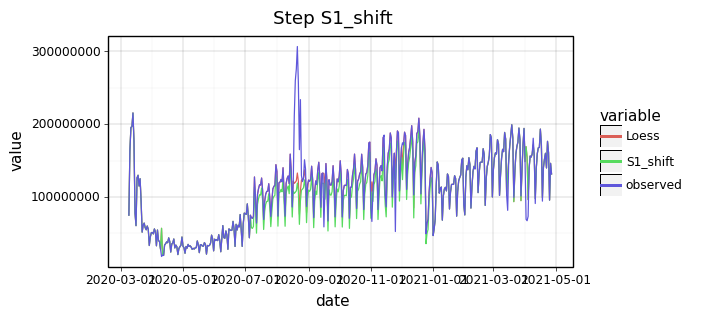

2021-04-28 21:10:30.909 | DEBUG    | src.runners.clean:_run_step:798 - ... step done ...
2021-04-28 21:10:30.913 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 21:10:30.914 | INFO     | src.runners.clean:_run_step:752 - Target variable: S1_shift 

2021-04-28 21:10:30.915 | DEBUG    | src.runners.clean:_find_anomalies:207 - 
... finding outliers ...
2021-04-28 21:10:30.916 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating S1_shift...

2021-04-28 21:10:30.921 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

<ggplot: (8745708368285)>
        date     S1_shift  anomaly_persist anomaly_seasonal  anomaly_autor  \
0 2020-03-09   74001430.0              NaN              NaN            NaN   
1 2020-03-10  163743625.0              NaN              NaN            NaN   
2 2020-03-11  195417551.0              NaN              NaN            NaN   
3 2020-03-12  196938136.0              NaN              NaN            NaN   
4 2020-03-13  215453447.0              NaN              NaN            NaN   

   anomaly_sum  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  


2021-04-28 21:10:31.699 | DEBUG    | src.runners.clean:_run_shift_grid:423 - Total combinations: 25

2021-04-28 21:10:31.964 | DEBUG    | src.runners.clean:_initial_shift_date:478 - Shift found at 2020-11-27 00:00:00
2021-04-28 21:10:31.968 | DEBUG    | src.runners.clean:_shift_ts:512 - 

2021-04-28 21:10:31.969 | DEBUG    | src.runners.clean:_shift_ts:513 - Center point: -14487876.108043477
../src/runners/clean.py:520: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:485: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


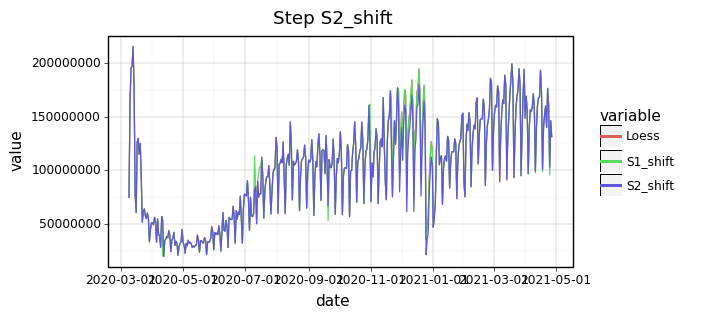

2021-04-28 21:10:32.385 | DEBUG    | src.runners.clean:_run_step:798 - ... step done ...
2021-04-28 21:10:32.551 | DEBUG    | src.runners.clean:_write_missing:685 - ... writing anomalies file ...


<ggplot: (8745694391081)>


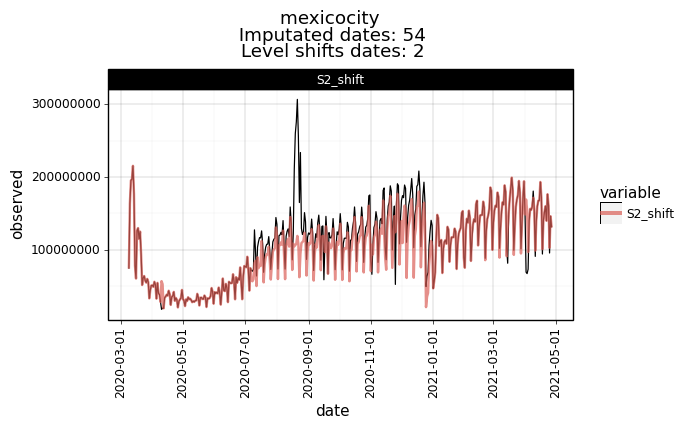

<ggplot: (8745695076765)>


/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_mexicocity.pdf
2021-04-28 21:10:34.447 | INFO     | src.runners.clean:_run_single:864 - ... mexicocity done ...



In [115]:
daily, weekly = _run_single(region_slug='mexicocity', 
                            anomaly_vote_minimun_s1=1, 
                            anomaly_vote_minimun_s2=1, 
                            c_metric = 'max', 
                            print_report = False, 
                            print_plot = True)

In [93]:
import plotnine as p9
p9.theme_set(p9.theme_linedraw()) # default theme

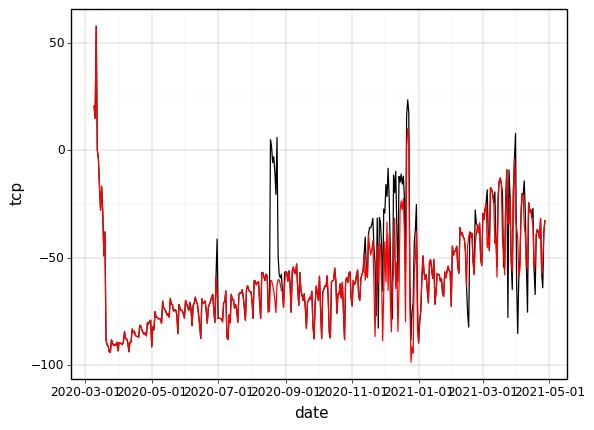

<ggplot: (8745680813117)>

In [95]:
daily.head(3)
gg = (p9.ggplot(daily, p9.aes(x = 'date', y='tcp')) 
 + p9.geom_line() 
 + p9.geom_line(p9.aes( y='tcp_clean'), color = 'red'))
gg 

In [31]:
weekly.head(3)
gg = (p9.ggplot(weekly, p9.aes(x = 'date_min', y='tcp')) 
 + p9.geom_line() 
 + p9.geom_line(p9.aes( y='tcp_clean'), color = 'red'))
#gg

In [101]:
print(daily.date.min())
print(daily.date.max())
print(weekly.week.max())

2020-03-09 00:00:00
2021-04-27 00:00:00
60


#### Run by batch

In [116]:
from src.runners.clean import _run_batch 

../src/utils.py:158: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.


In [136]:
_run_batch(athena_path = "/home/soniame/shared/spd-sdv-omitnik-waze/corona", 
          c_metric = 'max')

../src/utils.py:158: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
2021-04-28 22:40:22.945 | INFO     | src.runners.clean:_run_batch:880 - TO DO regions  81
2021-04-28 22:40:22.945 | INFO     | src.runners.clean:_run_single:814 - ... here we go aguascalientes...

2021-04-28 22:40:22.948 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('aguascalientes')
        


aguascalientes


2021-04-28 22:40:25.477 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.0273899198125596
2021-04-28 22:40:25.481 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:40:25.481 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:40:25.482 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:40:25.483 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:40:25.489 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

arequipa


2021-04-28 22:40:30.639 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.3707797834677795
2021-04-28 22:40:30.642 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:40:30.643 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:40:30.645 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:40:30.647 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:40:30.652 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-04-28 22:40:32.902 | DEBUG    | src.runners.clean:_write_missing:684 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_arequipa.pdf
2021-04-28 22:40:34.319 | INFO     | src.runners.clean:_run_single:864 - ... arequipa done ...

2021-04-28 22:40:34.320 | INFO     | src.runners.clean:_run_single:814 - ... here we go barranquilla...

2021-04-28 22:40:34.321 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('barranquilla')
        


barranquilla


2021-04-28 22:40:35.781 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.76668667025904
2021-04-28 22:40:35.784 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:40:35.785 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:40:35.785 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:40:35.786 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:40:35.792 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.76668667025904
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docume

2021-04-28 22:40:38.057 | DEBUG    | src.runners.clean:_write_missing:684 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_barranquilla.pdf
2021-04-28 22:40:39.369 | INFO     | src.runners.clean:_run_single:864 - ... barranquilla done ...

2021-04-28 22:40:39.371 | INFO     | src.runners.clean:_run_single:814 - ... here we go belem...

2021-04-28 22:40:39.374 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('belem')
        


belem


2021-04-28 22:40:40.880 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.6751306885065211
2021-04-28 22:40:40.884 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:40:40.885 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:40:40.885 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:40:40.887 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:40:40.892 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-04-28 22:40:44.783 | INFO     | src.runners.clean:_run_single:814 - ... here we go belohorizonte...

2021-04-28 22:40:44.784 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('belohorizonte')
        


belohorizonte


2021-04-28 22:40:48.941 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.7932268803995419
2021-04-28 22:40:48.945 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:40:48.946 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:40:48.947 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:40:48.950 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:40:48.954 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

bogota


2021-04-28 22:40:55.323 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.7885534354346917
2021-04-28 22:40:55.327 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:40:55.328 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:40:55.328 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:40:55.330 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:40:55.336 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.7885534354346917
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

brasilia


2021-04-28 22:41:00.953 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.045577611833902
2021-04-28 22:41:00.956 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:41:00.957 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:41:00.958 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:41:00.959 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:41:00.965 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: htt

bucaramanga


2021-04-28 22:41:06.387 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.6872269818077374
2021-04-28 22:41:06.390 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:41:06.391 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:41:06.391 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:41:06.393 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:41:06.399 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.6872269818077374
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_bucaramanga.pdf
2021-04-28 22:41:10.115 | INFO     | src.runners.clean:_run_single:864 - ... bucaramanga done ...

2021-04-28 22:41:10.116 | INFO     | src.runners.clean:_run_single:814 - ... here we go buenosaires...

2021-04-28 22:41:10.119 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('buenosaires')
        


buenosaires


2021-04-28 22:41:13.329 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.9098498045084976
2021-04-28 22:41:13.332 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:41:13.333 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:41:13.334 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:41:13.335 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:41:13.341 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

cali


2021-04-28 22:41:18.514 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.4587580136087392
2021-04-28 22:41:18.518 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:41:18.518 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:41:18.519 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:41:18.520 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:41:18.526 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-04-28 22:41:22.168 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('campinas')
        


campinas


2021-04-28 22:41:23.873 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.8807937888708207
2021-04-28 22:41:23.876 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:41:23.877 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:41:23.878 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:41:23.879 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:41:23.884 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

cartagena


2021-04-28 22:41:29.024 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.5510305787633392
2021-04-28 22:41:29.027 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:41:29.028 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:41:29.029 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:41:29.030 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:41:29.036 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5510305787633392
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

2021-04-28 22:41:32.905 | INFO     | src.runners.clean:_run_single:864 - ... cartagena done ...

2021-04-28 22:41:32.906 | INFO     | src.runners.clean:_run_single:814 - ... here we go cordoba...

2021-04-28 22:41:32.907 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('cordoba')
        


cordoba


2021-04-28 22:41:34.440 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.6189154013154357
2021-04-28 22:41:34.443 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:41:34.444 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:41:34.444 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:41:34.446 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:41:34.451 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.6189154013154357
2021-04-28 22:41:34.476 | DEBUG    | src.runners.clean:_outlier_seasonal_ad:101 - !! No Seasonal !!
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWa

country_argentina


2021-04-28 22:41:40.681 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.2809406370453256
2021-04-28 22:41:40.684 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:41:40.685 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:41:40.685 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:41:40.687 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:41:40.693 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-04-28 22:41:40.717 | DEBUG    | src.runners.clean:_outlier_seasonal_ad:101 - !! No Seasonal !!
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value

country_barbados


2021-04-28 22:41:47.059 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.9579304881178845
2021-04-28 22:41:47.062 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:41:47.063 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:41:47.063 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:41:47.064 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:41:47.071 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.9579304881178845
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

country_brazil


2021-04-28 22:41:53.573 | DEBUG    | src.runners.clean:_c_param:352 - C max: 3
2021-04-28 22:41:53.577 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:41:53.578 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:41:53.578 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:41:53.580 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:41:53.585 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 3
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

country_chile


2021-04-28 22:42:01.352 | DEBUG    | src.runners.clean:_c_param:352 - C max: 4.142744523852838
2021-04-28 22:42:01.356 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:42:01.356 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:42:01.357 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:42:01.358 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:42:01.363 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 3
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https

country_colombia


2021-04-28 22:42:06.624 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.691574492443756
2021-04-28 22:42:06.628 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:42:06.628 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:42:06.630 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:42:06.632 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:42:06.637 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.691574492443756
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docu

country_costa_rica


2021-04-28 22:42:11.638 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.6067585208477897
2021-04-28 22:42:11.642 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:42:11.642 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:42:11.643 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:42:11.644 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:42:11.650 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.6067585208477897
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

country_dominican_republic


2021-04-28 22:42:16.853 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.3351452315716383
2021-04-28 22:42:16.856 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:42:16.857 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:42:16.857 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:42:16.859 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:42:16.864 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-04-28 22:42:18.944 | DEBUG    | src.runners.clean:_shift_ts:512 - Center point: -8204688.957369313
../src/runners/clean.py:519: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:484: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2021-04-28 22:42:18.981 | DEBUG    | src.runners.clean:_run_step:798 - ... step done ...
2021-04-28 22:42:19.150 | DEBUG    | src.runners.clean:_write_missing:684 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-om

country_ecuador


2021-04-28 22:42:22.901 | DEBUG    | src.runners.clean:_c_param:352 - C max: 2.0178491790094
2021-04-28 22:42:22.904 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:42:22.905 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:42:22.906 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:42:22.907 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:42:22.913 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 2.0178491790094
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the document

country_el_salvador


2021-04-28 22:42:29.233 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.983635178740892
2021-04-28 22:42:29.237 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:42:29.238 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:42:29.240 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:42:29.241 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:42:29.245 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.983635178740892
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docu

country_guatemala


2021-04-28 22:42:34.259 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.3497639329038027
2021-04-28 22:42:34.262 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:42:34.263 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:42:34.264 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:42:34.265 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:42:34.272 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

country_honduras


2021-04-28 22:42:40.398 | DEBUG    | src.runners.clean:_c_param:352 - C max: 3
2021-04-28 22:42:40.401 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:42:40.402 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:42:40.402 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:42:40.403 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:42:40.409 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 3
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

country_jamaica


2021-04-28 22:42:45.407 | DEBUG    | src.runners.clean:_c_param:352 - C max: 2.1973952336567217
2021-04-28 22:42:45.410 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:42:45.411 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:42:45.412 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:42:45.413 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:42:45.418 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 2.1973952336567217
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

country_mexico


2021-04-28 22:42:50.734 | DEBUG    | src.runners.clean:_c_param:352 - C max: 3
2021-04-28 22:42:50.737 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:42:50.738 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:42:50.739 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:42:50.740 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:42:50.745 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 3
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

country_nicaragua


2021-04-28 22:42:55.877 | DEBUG    | src.runners.clean:_c_param:352 - C max: 3
2021-04-28 22:42:55.880 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:42:55.881 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:42:55.883 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:42:55.885 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:42:55.890 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 3
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

country_panama


2021-04-28 22:43:01.272 | DEBUG    | src.runners.clean:_c_param:352 - C max: 3
2021-04-28 22:43:01.275 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:43:01.276 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:43:01.278 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:43:01.280 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:43:01.284 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 3
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

country_paraguay


2021-04-28 22:43:06.377 | DEBUG    | src.runners.clean:_c_param:352 - C max: 3
2021-04-28 22:43:06.381 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:43:06.381 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:43:06.384 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:43:06.384 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:43:06.389 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 3
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

country_peru


2021-04-28 22:43:11.459 | DEBUG    | src.runners.clean:_c_param:352 - C max: 3
2021-04-28 22:43:11.462 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:43:11.463 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:43:11.465 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:43:11.466 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:43:11.471 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 3
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

country_trinidad_and_tobago


2021-04-28 22:43:16.848 | DEBUG    | src.runners.clean:_c_param:352 - C max: 3
2021-04-28 22:43:16.851 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:43:16.852 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:43:16.853 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:43:16.856 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:43:16.860 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 3
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

country_uruguay


2021-04-28 22:43:21.991 | DEBUG    | src.runners.clean:_c_param:352 - C max: 3
2021-04-28 22:43:21.994 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:43:21.995 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:43:21.996 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:43:21.997 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:43:22.003 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 3
2021-04-28 22:43:22.028 | DEBUG    | src.runners.clean:_outlier_seasonal_ad:101 - !! No Seasonal !!
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be se

cucuta


2021-04-28 22:43:28.112 | DEBUG    | src.runners.clean:_c_param:352 - C max: 2.077252636557924
2021-04-28 22:43:28.115 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:43:28.116 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:43:28.117 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:43:28.120 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:43:28.124 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 2.077252636557924
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docu

cuenca


2021-04-28 22:43:33.750 | DEBUG    | src.runners.clean:_c_param:352 - C max: 3.1014910267983185
2021-04-28 22:43:33.754 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:43:33.754 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:43:33.756 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:43:33.758 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:43:33.763 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 3
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http

curitiba


2021-04-28 22:43:39.139 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.5530162237918487
2021-04-28 22:43:39.143 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:43:39.143 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:43:39.144 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:43:39.145 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:43:39.151 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-04-28 22:43:42.878 | INFO     | src.runners.clean:_run_single:814 - ... here we go fortaleza...

2021-04-28 22:43:42.881 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('fortaleza')
        


fortaleza


2021-04-28 22:43:44.349 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.7847212471922886
2021-04-28 22:43:44.352 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:43:44.353 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:43:44.353 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:43:44.355 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:43:44.361 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-04-28 22:43:48.286 | INFO     | src.runners.clean:_run_single:814 - ... here we go goiania...

2021-04-28 22:43:48.288 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('goiania')
        


goiania


2021-04-28 22:43:49.871 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.6886402819581707
2021-04-28 22:43:49.874 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:43:49.875 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:43:49.875 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:43:49.877 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:43:49.883 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-04-28 22:43:52.144 | DEBUG    | src.runners.clean:_write_missing:684 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_goiania.pdf
2021-04-28 22:43:53.602 | INFO     | src.runners.clean:_run_single:864 - ... goiania done ...

2021-04-28 22:43:53.603 | INFO     | src.runners.clean:_run_single:814 - ... here we go guadalajara...

2021-04-28 22:43:53.604 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('guadalajara')
        


guadalajara


2021-04-28 22:43:56.285 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.341901667057806
2021-04-28 22:43:56.289 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:43:56.289 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:43:56.290 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:43:56.291 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:43:56.297 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: htt

guatemala


2021-04-28 22:44:01.540 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.6609323947431904
2021-04-28 22:44:01.544 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:44:01.545 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:44:01.545 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:44:01.547 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:44:01.553 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.6609323947431904
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

guayaquil


2021-04-28 22:44:06.740 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.0869959841260328
2021-04-28 22:44:06.743 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:44:06.744 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:44:06.744 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:44:06.746 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:44:06.752 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-04-28 22:44:09.021 | DEBUG    | src.runners.clean:_write_missing:684 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_guayaquil.pdf
2021-04-28 22:44:10.372 | INFO     | src.runners.clean:_run_single:864 - ... guayaquil done ...

2021-04-28 22:44:10.373 | INFO     | src.runners.clean:_run_single:814 - ... here we go joaopessoa...

2021-04-28 22:44:10.376 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('joaopessoa')
        


joaopessoa


2021-04-28 22:44:13.953 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.8329019561170704
2021-04-28 22:44:13.957 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:44:13.958 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:44:13.958 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:44:13.959 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:44:13.965 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

kingston


2021-04-28 22:44:19.654 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.4675734225846222
2021-04-28 22:44:19.657 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:44:19.658 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:44:19.659 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:44:19.660 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:44:19.665 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

leon


2021-04-28 22:44:26.880 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.6712063144721307
2021-04-28 22:44:26.883 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:44:26.884 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:44:26.885 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:44:26.886 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:44:26.892 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

lima


2021-04-28 22:44:33.475 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.3292364286255252
2021-04-28 22:44:33.479 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:44:33.480 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:44:33.480 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:44:33.482 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:44:33.488 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-04-28 22:44:34.657 | DEBUG    | src.runners.clean:_impute_anomalies:302 - 
... imputing outliers ...
2021-04-28 22:44:34.700 | INFO     | src.runners.clean:_run_step:770 - Output variable S2_shift
2021-04-28 22:44:34.700 | DEBUG    | src.runners.clean:_shift_level:535 - 

2021-04-28 22:44:34.701 | DEBUG    | src.runners.clean:_shift_level:536 - ... shifting levels for Loess ...
2021-04-28 22:44:34.703 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-04-28 22:44:34.708 | DEBUG    | src.runners.clean:_run_shift_grid:402 - ... shift level running grid  ...

2021-04-28 22:44:35.332 | DEBUG    | src.runners.clean:_run_shift_grid:422 - Total combinations: 25

2021-04-28 22:44:35.566 | DEBUG    | src.runners.clean:_initial_shift_date:477 - Shift found at 2020-12-10 00:00:00
2021-04-28 22:44:35.569 | DEBUG    | src.runners.clean:_shift_ts:511 - 

2021-04-28 22:44:35.570 | DEBUG    | src.runners.clean:_shift_ts:512 - Center point: -10399397.463500023
../sr

maceio


2021-04-28 22:44:38.660 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.6694820447662065
2021-04-28 22:44:38.664 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:44:38.664 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:44:38.665 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:44:38.666 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:44:38.671 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-04-28 22:44:42.415 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('managua')
        


managua


2021-04-28 22:44:44.879 | DEBUG    | src.runners.clean:_c_param:352 - C max: 2.3062522483739114
2021-04-28 22:44:44.882 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:44:44.883 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:44:44.883 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:44:44.885 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:44:44.890 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 2.3062522483739114
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

2021-04-28 22:44:48.729 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('manaus')
        


manaus


2021-04-28 22:44:50.157 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.8762962595307018
2021-04-28 22:44:50.160 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:44:50.161 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:44:50.161 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:44:50.163 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:44:50.169 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-04-28 22:44:52.444 | DEBUG    | src.runners.clean:_write_missing:684 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_manaus.pdf
2021-04-28 22:44:53.861 | INFO     | src.runners.clean:_run_single:864 - ... manaus done ...

2021-04-28 22:44:53.862 | INFO     | src.runners.clean:_run_single:814 - ... here we go medellin...

2021-04-28 22:44:53.863 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('medellin')
        


medellin


2021-04-28 22:44:55.365 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.0561541424862373
2021-04-28 22:44:55.368 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:44:55.369 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:44:55.370 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:44:55.371 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:44:55.377 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_medellin.pdf
2021-04-28 22:44:59.053 | INFO     | src.runners.clean:_run_single:864 - ... medellin done ...

2021-04-28 22:44:59.055 | INFO     | src.runners.clean:_run_single:814 - ... here we go merida...

2021-04-28 22:44:59.055 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('merida')
        


merida


2021-04-28 22:45:02.590 | DEBUG    | src.runners.clean:_c_param:352 - C max: 2.846122525561435
2021-04-28 22:45:02.594 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:45:02.595 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:45:02.595 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:45:02.596 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:45:02.603 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 2.846122525561435
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docu

mexicocity


2021-04-28 22:45:09.876 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.2739730879698026
2021-04-28 22:45:09.880 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:45:09.881 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:45:09.882 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:45:09.883 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:45:09.889 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

monterrey


2021-04-28 22:45:15.142 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.0541138630388942
2021-04-28 22:45:15.145 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:45:15.146 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:45:15.146 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:45:15.148 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:45:15.154 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

montevideo


2021-04-28 22:45:20.621 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.8200260736553959
2021-04-28 22:45:20.624 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:45:20.625 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:45:20.626 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:45:20.627 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:45:20.632 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
2021-04-28 22:45:20.658 | DEBUG    | src.runners.clean:_outlier_seasonal_ad:101 - !! No Seasonal !!
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value

natal


2021-04-28 22:45:28.246 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.0880442257594305
2021-04-28 22:45:28.250 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:45:28.251 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:45:28.251 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:45:28.252 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:45:28.259 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-04-28 22:45:30.536 | DEBUG    | src.runners.clean:_write_missing:684 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_natal.pdf
2021-04-28 22:45:31.897 | INFO     | src.runners.clean:_run_single:864 - ... natal done ...

2021-04-28 22:45:31.898 | INFO     | src.runners.clean:_run_single:814 - ... here we go panamacity...

2021-04-28 22:45:31.899 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('panamacity')
        


panamacity


2021-04-28 22:45:33.370 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.1945219445657078
2021-04-28 22:45:33.373 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:45:33.374 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:45:33.375 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:45:33.376 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:45:33.382 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-04-28 22:45:35.679 | DEBUG    | src.runners.clean:_write_missing:684 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_panamacity.pdf
2021-04-28 22:45:37.072 | INFO     | src.runners.clean:_run_single:864 - ... panamacity done ...

2021-04-28 22:45:37.073 | INFO     | src.runners.clean:_run_single:814 - ... here we go pereira...

2021-04-28 22:45:37.074 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('pereira')
        


pereira


2021-04-28 22:45:40.529 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.3991602224679982
2021-04-28 22:45:40.532 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:45:40.533 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:45:40.534 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:45:40.535 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:45:40.541 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

porto_alergre


2021-04-28 22:45:47.005 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.5064590067301696
2021-04-28 22:45:47.009 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:45:47.009 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:45:47.010 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:45:47.011 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:45:47.017 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-04-28 22:45:51.013 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('pueble')
        


pueble


2021-04-28 22:45:52.613 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.145334843552123
2021-04-28 22:45:52.617 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:45:52.618 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:45:52.618 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:45:52.620 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:45:52.625 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: htt

queretaro


2021-04-28 22:45:57.830 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.0217022006577623
2021-04-28 22:45:57.834 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:45:57.835 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:45:57.836 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:45:57.838 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:45:57.843 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

quito


2021-04-28 22:46:04.235 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.4020956452000344
2021-04-28 22:46:04.239 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:46:04.240 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:46:04.240 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:46:04.242 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:46:04.247 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_quito.pdf
2021-04-28 22:46:08.441 | INFO     | src.runners.clean:_run_single:864 - ... quito done ...

2021-04-28 22:46:08.443 | INFO     | src.runners.clean:_run_single:814 - ... here we go recife...

2021-04-28 22:46:08.444 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('recife')
        


recife


2021-04-28 22:46:09.966 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.7276713646191327
2021-04-28 22:46:09.969 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:46:09.970 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:46:09.973 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:46:09.973 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:46:09.978 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

riodejaneiro


2021-04-28 22:46:15.785 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.7051065215962252
2021-04-28 22:46:15.789 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:46:15.790 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:46:15.790 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:46:15.792 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:46:15.798 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-04-28 22:46:19.730 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('rosario')
        


rosario


2021-04-28 22:46:22.245 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.6300638242855072
2021-04-28 22:46:22.248 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:46:22.249 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:46:22.249 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:46:22.251 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:46:22.257 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.6300638242855072
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

salvador


2021-04-28 22:46:28.471 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.7570923944305465
2021-04-28 22:46:28.474 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:46:28.475 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:46:28.476 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:46:28.477 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:46:28.483 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

sanjose


2021-04-28 22:46:34.822 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.4722106991438355
2021-04-28 22:46:34.826 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:46:34.827 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:46:34.827 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:46:34.828 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:46:34.834 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-04-28 22:46:38.571 | INFO     | src.runners.clean:_run_single:864 - ... sanjose done ...

2021-04-28 22:46:38.573 | INFO     | src.runners.clean:_run_single:814 - ... here we go sanluispotosi...

2021-04-28 22:46:38.576 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('sanluispotosi')
        


sanluispotosi


2021-04-28 22:46:40.204 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.6554248545597523
2021-04-28 22:46:40.207 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:46:40.208 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:46:40.209 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:46:40.210 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:46:40.215 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.6554248545597523
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

sansalvador


2021-04-28 22:46:45.407 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.4512411316196725
2021-04-28 22:46:45.410 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:46:45.411 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:46:45.412 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:46:45.413 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:46:45.420 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

../src/runners/clean.py:519: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:484: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2021-04-28 22:46:47.522 | DEBUG    | src.runners.clean:_run_step:798 - ... step done ...
2021-04-28 22:46:47.690 | DEBUG    | src.runners.clean:_write_missing:684 - ... writing anomalies file ...
/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_sansalvador.pdf
2021-04-28 22:46:49.132 | INFO     | src.runners

santacruzdelasierra


2021-04-28 22:46:50.535 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.2474824730113303
2021-04-28 22:46:50.540 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:46:50.540 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:46:50.541 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:46:50.542 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:46:50.548 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-04-28 22:46:54.393 | INFO     | src.runners.clean:_run_single:864 - ... santacruzdelasierra done ...

2021-04-28 22:46:54.395 | INFO     | src.runners.clean:_run_single:814 - ... here we go santamarta...

2021-04-28 22:46:54.395 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('santamarta')
        


santamarta


2021-04-28 22:46:55.812 | DEBUG    | src.runners.clean:_c_param:352 - C max: 5.851182967075816
2021-04-28 22:46:55.815 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:46:55.816 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:46:55.818 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:46:55.820 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:46:55.825 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 3
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https

santiago


2021-04-28 22:47:01.281 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.7238798250564803
2021-04-28 22:47:01.285 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:47:01.285 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:47:01.287 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:47:01.288 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:47:01.294 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_santiago.pdf
2021-04-28 22:47:04.994 | INFO     | src.runners.clean:_run_single:864 - ... santiago done ...

2021-04-28 22:47:04.995 | INFO     | src.runners.clean:_run_single:814 - ... here we go santiagocaballeros...

2021-04-28 22:47:04.996 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('santiagocaballeros')
        


santiagocaballeros


2021-04-28 22:47:08.464 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.4943365380804419
2021-04-28 22:47:08.468 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:47:08.468 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:47:08.470 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:47:08.472 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:47:08.477 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-04-28 22:47:09.646 | DEBUG    | src.runners.clean:_impute_anomalies:302 - 
... imputing outliers ...
2021-04-28 22:47:09.690 | INFO     | src.runners.clean:_run_step:770 - Output variable S2_shift
2021-04-28 22:47:09.691 | DEBUG    | src.runners.clean:_shift_level:535 - 

2021-04-28 22:47:09.691 | DEBUG    | src.runners.clean:_shift_level:536 - ... shifting levels for Loess ...
2021-04-28 22:47:09.694 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating Loess...

2021-04-28 22:47:09.700 | DEBUG    | src.runners.clean:_run_shift_grid:402 - ... shift level running grid  ...

2021-04-28 22:47:10.318 | DEBUG    | src.runners.clean:_run_shift_grid:422 - Total combinations: 25

2021-04-28 22:47:10.550 | DEBUG    | src.runners.clean:_initial_shift_date:477 - Shift found at 2020-12-07 00:00:00
2021-04-28 22:47:10.553 | DEBUG    | src.runners.clean:_shift_ts:511 - 

2021-04-28 22:47:10.554 | DEBUG    | src.runners.clean:_shift_ts:512 - Center point: -975820.061357908
../src/

santodomingo


2021-04-28 22:47:14.410 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.3523040362739855
2021-04-28 22:47:14.413 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:47:14.414 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:47:14.415 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:47:14.416 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:47:14.421 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-04-28 22:47:16.526 | DEBUG    | src.runners.clean:_initial_shift_date:477 - Shift found at 2020-05-19 00:00:00
2021-04-28 22:47:16.529 | DEBUG    | src.runners.clean:_shift_ts:511 - 

2021-04-28 22:47:16.530 | DEBUG    | src.runners.clean:_shift_ts:512 - Center point: -5832747.428571432
../src/runners/clean.py:519: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:484: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2021-04-28 22:47:16.567 | DEBUG    | src.runners.clean:_run_step:798 - ... step done ...
2021-04-28 22:47:16.738 | DEBUG    | src.runners.clean:_write_missing:684 - ... writing anomalies 

santos


2021-04-28 22:47:19.713 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.7896025576544832
2021-04-28 22:47:19.720 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:47:19.720 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:47:19.723 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:47:19.726 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:47:19.733 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.7896025576544832
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

saojosedoscampos


2021-04-28 22:47:25.316 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.5223668037712927
2021-04-28 22:47:25.320 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:47:25.320 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:47:25.321 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:47:25.321 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:47:25.327 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5223668037712927
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the do

saoluis


2021-04-28 22:47:31.704 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.0670831789268076
2021-04-28 22:47:31.708 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:47:31.708 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:47:31.710 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:47:31.712 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:47:31.717 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

saopaulo


2021-04-28 22:47:38.478 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.9716867880970144
2021-04-28 22:47:38.482 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:47:38.483 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:47:38.483 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:47:38.485 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:47:38.491 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-04-28 22:47:42.183 | INFO     | src.runners.clean:_run_single:864 - ... saopaulo done ...

2021-04-28 22:47:42.185 | INFO     | src.runners.clean:_run_single:814 - ... here we go sorocaba...

2021-04-28 22:47:42.188 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('sorocaba')
        


sorocaba


2021-04-28 22:47:45.685 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.3518559706673363
2021-04-28 22:47:45.689 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:47:45.690 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:47:45.690 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:47:45.692 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:47:45.697 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

/home/soniame/.conda/envs/IDB-IDB-Invest-Coronavirus-Impact-Dashboard/lib/python3.7/site-packages/plotnine/ggplot.py:848: PlotnineWarning: Filename: /home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/figures/plot_sorocaba.pdf
2021-04-28 22:47:49.439 | INFO     | src.runners.clean:_run_single:864 - ... sorocaba done ...

2021-04-28 22:47:49.440 | INFO     | src.runners.clean:_run_single:814 - ... here we go tegucigalpa...

2021-04-28 22:47:49.444 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('tegucigalpa')
        


tegucigalpa


2021-04-28 22:47:51.936 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.4825062790341532
2021-04-28 22:47:51.940 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:47:51.940 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:47:51.941 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:47:51.944 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:47:51.949 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

2021-04-28 22:47:55.729 | INFO     | src.runners.clean:_run_single:864 - ... tegucigalpa done ...

2021-04-28 22:47:55.731 | INFO     | src.runners.clean:_run_single:814 - ... here we go teresina...

2021-04-28 22:47:55.732 | DEBUG    | src.runners.clean:_reading_data:677 - 
        select 
            *,
            date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
        from spd_sdv_waze_corona.prod_daily_daily_index
        where region_slug in ('teresina')
        


teresina


2021-04-28 22:47:57.178 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.9721586604894438
2021-04-28 22:47:57.181 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:47:57.182 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:47:57.183 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:47:57.184 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:47:57.189 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

toluca


2021-04-28 22:48:03.581 | DEBUG    | src.runners.clean:_c_param:352 - C max: 1.0739196312627826
2021-04-28 22:48:03.585 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:48:03.586 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:48:03.586 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:48:03.587 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:48:03.593 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

torreon


2021-04-28 22:48:09.846 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.7849571168548051
2021-04-28 22:48:09.849 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:48:09.850 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:48:09.852 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:48:09.853 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:48:09.859 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

vitoria


2021-04-28 22:48:16.265 | DEBUG    | src.runners.clean:_c_param:352 - C max: 0.8880699427405386
2021-04-28 22:48:16.269 | DEBUG    | src.runners.clean:_run_step:751 - ... step start ...
2021-04-28 22:48:16.270 | INFO     | src.runners.clean:_run_step:752 - Target variable: observed 

2021-04-28 22:48:16.271 | DEBUG    | src.runners.clean:_find_anomalies:206 - 
... finding outliers ...
2021-04-28 22:48:16.272 | DEBUG    | src.runners.clean:_validate_series:55 - ... validating observed...

2021-04-28 22:48:16.277 | DEBUG    | src.runners.clean:_c_trun:137 - C truncated: 1.5
../src/runners/clean.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
../src/runners/clean.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

## Comparison

### Daily

In [155]:
import pandas as pd
from siuba import *
df_max = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/daily/daily_daily_index_max.csv")
df_aut = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/daily/daily_daily_index_max_autoreg.csv")
df_sea = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/daily/daily_daily_index_max_seasonal.csv")
df_per = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/daily/daily_daily_index_max_persist.csv")

df_max = df_max[['date', 'region_slug', 'tci_observed', 'tcp_observed', 'tci_clean', 'tcp_clean']] \
    .rename(columns = {'tci_clean':'tci_max', 
                       'tcp_clean':'tcp_max'}) 
df_aut = df_aut[['date', 'region_slug', 'tci_observed', 'tcp_observed', 'tci_clean', 'tcp_clean']] \
    .rename(columns = {'tci_clean':'tci_aut', 
                       'tcp_clean':'tcp_aut'})
df_sea = df_sea[['date', 'region_slug', 'tci_observed', 'tcp_observed', 'tci_clean', 'tcp_clean']] \
    .rename(columns = {'tci_clean':'tci_sea', 
                       'tcp_clean':'tcp_sea'})
df_per = df_per[['date', 'region_slug', 'tci_observed', 'tcp_observed', 'tci_clean', 'tcp_clean']] \
    .rename(columns = {'tci_clean':'tci_per', 
                       'tcp_clean':'tcp_per'})


In [156]:
print(df_max.shape)
print(df_aut.shape)
print(df_sea.shape)
print(df_per.shape)

(33615, 6)
(33615, 6)
(33615, 6)
(33615, 6)


In [157]:
df_union = df_max \
    .merge(df_aut) \
    .merge(df_sea) \
    .merge(df_per)
df_union.describe()

,tci_observed,tcp_observed,tci_max,tcp_max,tci_aut,tcp_aut,tci_sea,tcp_sea,tci_per,tcp_per
count,3.361500e+04,33615.000000,3.361500e+04,33615.000000,3.361500e+04,33615.000000,3.361500e+04,33615.000000,3.361500e+04,33615.000000
mean,3.954611e+07,-34.252950,3.363680e+07,-43.915362,3.378722e+07,-42.951252,3.017714e+07,-41.571271,2.985194e+07,-43.099580
std,1.520573e+08,49.718902,1.237370e+08,37.765377,1.243541e+08,40.730783,1.043018e+08,43.826962,1.025014e+08,39.196495
min,1.392000e+03,-99.842676,1.275478e+03,-99.918510,1.392000e+03,-99.842676,1.392000e+03,-99.929284,1.392000e+03,-99.978106
25%,2.225108e+06,-68.301702,1.904300e+06,-69.930822,1.936527e+06,-70.103313,1.933186e+06,-70.728528,1.899293e+06,-70.157101
50%,7.165943e+06,-41.162883,6.116879e+06,-49.545325,6.232853e+06,-49.312562,6.302531e+06,-49.415367,6.274105e+06,-49.596394
75%,2.083909e+07,-12.278235,1.865634e+07,-25.301824,1.856198e+07,-24.098999,1.931468e+07,-21.267099,1.913413e+07,-23.681652
max,3.742041e+09,1036.781062,1.827197e+09,341.732005,1.827197e+09,1007.145037,1.827197e+09,1007.145037,1.827197e+09,341.732005


In [158]:
df_union.to_csv("/home/soniame/private/daily_index_index.csv")

In [159]:
df_union[df_union.region_slug == 'lima'].head()

,date,region_slug,tci_observed,tcp_observed,tci_max,tcp_max,tci_aut,tcp_aut,tci_sea,tcp_sea,tci_per,tcp_per
17845,2021-02-12,lima,39224027,-58.577608,3.922403e+07,-58.577608,3.922403e+07,-58.577608,3.922403e+07,-58.577608,3.922403e+07,-58.577608
17846,2021-03-05,lima,79195000,-16.366405,5.885859e+07,-37.842602,5.885859e+07,-37.842602,7.919500e+07,-16.366405,7.919500e+07,-16.366405
17847,2020-11-13,lima,71231508,-24.776222,6.776126e+07,-28.440960,6.776126e+07,-28.440960,6.620437e+07,-30.085111,6.620437e+07,-30.085111
17848,2020-03-20,lima,6520522,-93.114026,6.520522e+06,-93.114026,6.520522e+06,-93.114026,6.520522e+06,-93.114026,6.520522e+06,-93.114026
17849,2021-02-05,lima,33056394,-65.090914,5.715661e+07,-39.639970,5.715661e+07,-39.639970,3.305639e+07,-65.090914,3.305639e+07,-65.090914


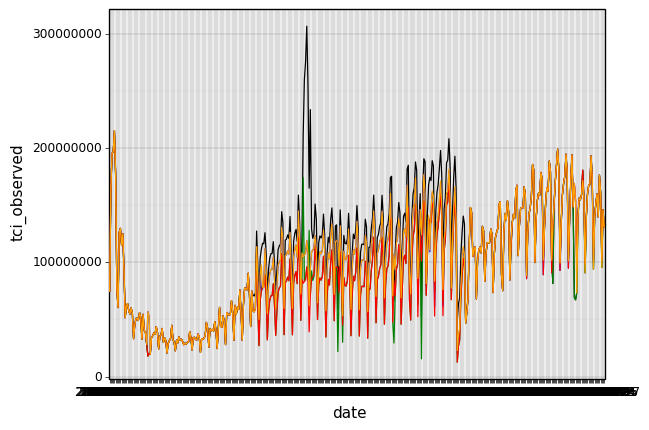

<ggplot: (8745688991069)>

In [160]:
gg = (p9.ggplot(df_union[df_union.region_slug == 'mexicocity'],
                    p9.aes(x = 'date', y='tci_observed', group = 'region_slug')) 
 + p9.geom_line() 
 + p9.geom_line(p9.aes( y='tci_max'), color = 'blue')
 + p9.geom_line(p9.aes( y='tci_sea'), color = 'green')
 + p9.geom_line(p9.aes( y='tci_per'), color = 'red')
 + p9.geom_line(p9.aes( y='tci_aut'), color = 'orange'))
gg

### Weekly

In [161]:

df_max = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/weekly/weekly_weekly_index_max.csv")
df_aut = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/weekly/weekly_weekly_index_max_autoreg.csv")
df_sea = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/weekly/weekly_weekly_index_max_seasonal.csv")
df_per = pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/cleaning/weekly/weekly_weekly_index_max_persist.csv")

df_max = df_max[df_max.days_num == 7][['week', 'days_num', 'region_slug', 'tci_observed', 'tcp_observed', 'tci_clean', 'tcp_clean']] \
    .rename(columns = {'tci_clean':'tci_max', 
                       'tcp_clean':'tcp_max'}) 
df_aut = df_aut[['week', 'region_slug', 'tci_observed', 'tcp_observed', 'tci_clean', 'tcp_clean']] \
    .rename(columns = {'tci_clean':'tci_aut', 
                       'tcp_clean':'tcp_aut'})
df_sea = df_sea[['week', 'region_slug', 'tci_observed', 'tcp_observed', 'tci_clean', 'tcp_clean']] \
    .rename(columns = {'tci_clean':'tci_sea', 
                       'tcp_clean':'tcp_sea'})
df_per = df_per[['week', 'region_slug', 'tci_observed', 'tcp_observed', 'tci_clean', 'tcp_clean']] \
    .rename(columns = {'tci_clean':'tci_per', 
                       'tcp_clean':'tcp_per'})


In [162]:
print(df_max.shape)
print(df_aut.shape)
print(df_sea.shape)
print(df_per.shape)

(4779, 7)
(4860, 6)
(4860, 6)
(4860, 6)


In [170]:
df_union = df_max \
    .merge(df_aut) \
    .merge(df_sea) \
    .merge(df_per)
df_union.describe()

,week,days_num,tci_observed,tcp_observed,tci_max,tcp_max,tci_aut,tcp_aut,tci_sea,tcp_sea,tci_per,tcp_per
count,4779.000000,4779.0,4.779000e+03,4779.000000,4.779000e+03,4779.000000,4.779000e+03,4779.000000,4.779000e+03,4779.000000,4.779000e+03,4779.000000
mean,30.000000,7.0,2.764137e+08,-36.244785,2.348605e+08,-44.947677,2.359191e+08,-44.164157,2.105166e+08,-43.132359,2.082314e+08,-44.384115
std,17.031168,0.0,1.040089e+09,42.783760,8.449130e+08,33.860024,8.487179e+08,35.628831,7.055188e+08,37.782724,6.955354e+08,34.564868
min,1.000000,7.0,1.082540e+05,-98.661365,1.082540e+05,-98.661365,1.082540e+05,-98.661365,1.082540e+05,-98.661365,1.082540e+05,-98.661365
25%,15.000000,7.0,1.707992e+07,-66.167167,1.511563e+07,-67.779512,1.527896e+07,-67.868217,1.535842e+07,-68.159418,1.500284e+07,-67.962097
50%,30.000000,7.0,5.352857e+07,-39.267594,4.719276e+07,-49.321772,4.763255e+07,-49.185327,4.774937e+07,-49.145335,4.852793e+07,-49.507892
75%,45.000000,7.0,1.461753e+08,-15.722526,1.314023e+08,-27.721156,1.295237e+08,-26.379667,1.356126e+08,-24.627462,1.332937e+08,-26.157640
max,59.000000,7.0,1.931785e+10,486.853576,1.065629e+10,263.381367,1.065629e+10,345.287852,1.065629e+10,345.287852,1.065629e+10,276.457304


In [171]:
df_union.head()

,week,days_num,region_slug,tci_observed,tcp_observed,tci_max,tcp_max,tci_aut,tcp_aut,tci_sea,tcp_sea,tci_per,tcp_per
0,1,7,aguascalientes,18414201,-0.072327,18414201.0,-0.072327,18414201.0,-0.072327,18414201.0,-0.072327,18414201.0,-0.072327
1,2,7,aguascalientes,9578544,-48.020464,9578544.0,-48.020464,9578544.0,-48.020464,9578544.0,-48.020464,9578544.0,-48.020464
2,3,7,aguascalientes,5471700,-70.306925,5471700.0,-70.306925,5471700.0,-70.306925,5471700.0,-70.306925,5471700.0,-70.306925
3,4,7,aguascalientes,4701122,-74.488593,4701122.0,-74.488593,4701122.0,-74.488593,4701122.0,-74.488593,4701122.0,-74.488593
4,5,7,aguascalientes,3838557,-79.169443,3838557.0,-79.169443,3838557.0,-79.169443,3838557.0,-79.169443,3838557.0,-79.169443


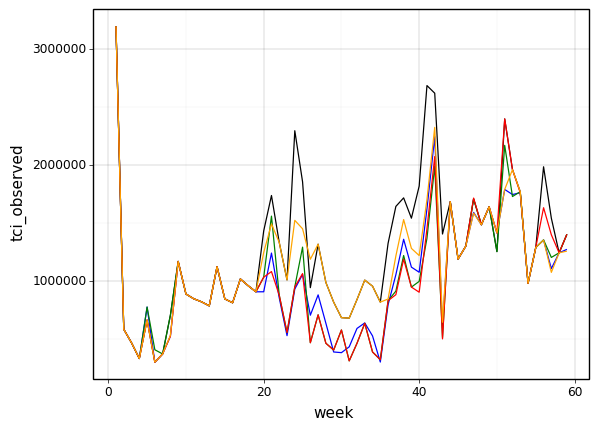

<ggplot: (8745682400845)>

In [169]:
gg = (p9.ggplot(df_union[df_union.region_slug == 'kingston'],
                    p9.aes(x = 'week', y='tci_observed', group = 'region_slug')) 
 + p9.geom_line() 
 + p9.geom_line(p9.aes( y='tci_max'), color = 'blue')
 + p9.geom_line(p9.aes( y='tci_sea'), color = 'green')
 + p9.geom_line(p9.aes( y='tci_per'), color = 'red')
 + p9.geom_line(p9.aes( y='tci_aut'), color = 'orange'))
gg

In [165]:
df_union.to_csv("/home/soniame/private/weekly_weekly_index.csv")

In [50]:
#plt.scatter(df.tcp, df.tcp_clean)
#df[['date', 'region_slug', 'tcp_clean']] 

In [72]:
df.region_slug.unique()[:5]

NameError: name 'df' is not defined

In [52]:
(df
 >> group_by('region_slug')
 >> summarize(min_tcp = _.tcp_clean.abs().min(),
              max_tcp = _.tcp_clean.abs().max(), 
              min_baseline = _.expected_2020.abs().min()/1e6,
              max_baseline = _.expected_2020.abs().max()/1e6,
              min_observed = _.observed.abs().min()/1e6,
              max_observed = _.observed.abs().max()/1e6,
              min_cleaned = _.S2_shift.abs().min()/1e6,
              max_cleaned = _.S2_shift.abs().max()/1e6
              )
 >> arrange(_.max_tcp)
).tail(15)

NameError: name 'df' is not defined

#### Step run

In [ ]:
df_cty = _load_data()

In [ ]:
df_run_1 = _run_step(df_run = df_cty[['date', 'S1_shift']].sort_values(by=['date']),
                         anomaly_vote_minimun = 1, 
                         c_param=_c_param(region_slug),
                         target_column_name = 'S1_shift',
                         output_column_name = 'S2_shift',
                         print_report = False, 
                         print_plot = True)

In [ ]:
df_run_1.head()

In [ ]:
df_run_2 = _run_step(df_run = df_run_1[['date', 'S1_shift']].sort_values(by=['date']),
                         anomaly_vote_minimun = 1, 
                         c_param=_c_param(region_slug),
                         target_column_name = 'S1_shift',
                         output_column_name = 'S2_shift',
                         print_report = False, 
                         print_plot = True)

In [ ]:
qry = """
select 
    *
from spd_sdv_waze_corona.prod_daily_weekly_index
limit 10
"""
df = pd.read_sql_query(qry, conn)

In [ ]:
df.columns #sort_values('week_number')

In [ ]:
import pandas as pd
metadata = pd.read_csv("http://tiny.cc/idb-traffic-metadata")

In [ ]:
print(len(metadata.region_slug))
print(metadata.region_slug.unique())

metadata.head()

In [ ]:
metadata[metadata.region_slug == 'mexicocity'].region_shapefile_wkt.to_list()